<a href="https://colab.research.google.com/github/mar25-iia2-radiographies/01_data_exploration/blob/main/03_lung_segmentation_unet_romuald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🫁 Segmentation Pulmonaire - U-Net

## Notebook 03 : Entraînement du modèle de segmentation

### Contexte
Suite aux conclusions des notebooks précédents :
- **Notebook 01** : Exploration → 21 165 images (299×299) + masques, grayscale
- **Notebook 02** : Preprocessing → CLAHE + Masque = meilleure approche

### Objectif
Entraîner un modèle U-Net pour générer automatiquement des masques pulmonaires de haute qualité.

### Stack
- **PyTorch** + **segmentation-models-pytorch**
- **Albumentations** pour l'augmentation
- **CLAHE** intégré au preprocessing (cf. conclusions notebook 02)

## 1. Installation des dépendances

In [1]:
!pip install -q segmentation-models-pytorch albumentations opencv-python-headless tqdm kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.0 MB/s eta 0:00:00


## 2. Imports et configuration

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Seed pour reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🖥️ Device: cuda
🎮 GPU: Tesla T4
💾 VRAM: 15.8 GB


## 3. Configuration et hyperparamètres

Paramètres basés sur les conclusions du notebook 02 :
- CLAHE intégré au preprocessing
- Seuils outliers : 65/190
- Images originales : 299×299

In [3]:
# ==================== CONFIGURATION ====================

# Taille originale des images du dataset
ORIGINAL_SIZE = 299

# Hyperparamètres d'entraînement
IMG_SIZE = 256              # Taille d'entrée du réseau (redimensionnée)
BATCH_SIZE = 16             # Réduire à 8 si OOM
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_WORKERS = 4             # 0 sur Windows si erreur

# Architecture U-Net
ENCODER = 'resnet34'        # Options: resnet18, resnet34, resnet50, efficientnet-b0
ENCODER_WEIGHTS = 'imagenet'

# Preprocessing (conclusions notebook 02)
APPLY_CLAHE = True          # CLAHE améliore le contraste
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_SIZE = (8, 8)

# Seuils outliers (ajustés notebook 02)
OUTLIER_LOW = 65
OUTLIER_HIGH = 190

# Catégories à utiliser (toutes pour la segmentation)
CATEGORIES = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

print("✅ Configuration chargée")
print(f"   - Taille originale: {ORIGINAL_SIZE}x{ORIGINAL_SIZE}")
print(f"   - Taille réseau: {IMG_SIZE}x{IMG_SIZE}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Encoder: {ENCODER}")
print(f"   - CLAHE: {APPLY_CLAHE}")

✅ Configuration chargée
   - Taille originale: 299x299
   - Taille réseau: 256x256
   - Batch size: 16
   - Encoder: resnet34
   - CLAHE: True


## 4. Chargement du dataset

In [4]:
import kagglehub

# Téléchargement du dataset
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
base_path = Path(path)
data_path = base_path / "COVID-19_Radiography_Dataset"

print(f"✅ Dataset téléchargé: {base_path}")
print(f"📁 Data path: {data_path}")

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
✅ Dataset téléchargé: /kaggle/input/covid19-radiography-database
📁 Data path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset


In [5]:
# Construction des paires image/masque
print("\n🔄 Construction des paires image/masque...")

pairs = []  # (image_path, mask_path, category)

for cat in CATEGORIES:
    img_dir = data_path / cat / "images"
    mask_dir = data_path / cat / "masks"

    if not img_dir.exists() or not mask_dir.exists():
        print(f"⚠️ Dossier manquant pour {cat}")
        continue

    images = sorted(list(img_dir.glob("*.png")))
    count = 0

    for img_path in images:
        mask_path = mask_dir / img_path.name
        if mask_path.exists():
            pairs.append({
                'image': str(img_path),
                'mask': str(mask_path),
                'category': cat
            })
            count += 1

    print(f"   {cat:20s}: {count:>6,} paires")

df_pairs = pd.DataFrame(pairs)
print(f"\n🎯 Total: {len(df_pairs):,} paires image/masque")


🔄 Construction des paires image/masque...
   COVID               :  3,616 paires
   Normal              : 10,192 paires
   Lung_Opacity        :  6,012 paires
   Viral Pneumonia     :  1,345 paires

🎯 Total: 21,165 paires image/masque


## 5. Vérification des tailles images/masques

⚠️ **Important**: Les masques peuvent avoir une taille différente des images. On vérifie cela.

In [6]:
# Vérification des tailles sur un échantillon
print("🔍 Vérification des tailles images/masques...")

sample_indices = np.random.choice(len(df_pairs), min(100, len(df_pairs)), replace=False)

img_sizes = []
mask_sizes = []
mismatches = 0

for idx in sample_indices:
    row = df_pairs.iloc[idx]
    img = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)

    if img is not None and mask is not None:
        img_sizes.append(img.shape)
        mask_sizes.append(mask.shape)
        if img.shape != mask.shape:
            mismatches += 1

print(f"\n📊 Résultats (échantillon de {len(sample_indices)} paires):")
print(f"   Tailles images uniques: {set(img_sizes)}")
print(f"   Tailles masques uniques: {set(mask_sizes)}")
print(f"   ⚠️ Paires avec tailles différentes: {mismatches}")

if mismatches > 0:
    print(f"\n   → Les masques seront redimensionnés à {ORIGINAL_SIZE}x{ORIGINAL_SIZE} dans le Dataset")

🔍 Vérification des tailles images/masques...

📊 Résultats (échantillon de 100 paires):
   Tailles images uniques: {(299, 299)}
   Tailles masques uniques: {(256, 256)}
   ⚠️ Paires avec tailles différentes: 100

   → Les masques seront redimensionnés à 299x299 dans le Dataset


## 6. Split Train/Val/Test

In [7]:
# Split stratifié par catégorie (70/15/15)
train_df, temp_df = train_test_split(
    df_pairs,
    test_size=0.3,
    random_state=SEED,
    stratify=df_pairs['category']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_df['category']
)

print(f"📊 Split des données:")
print(f"   Train: {len(train_df):>6,} ({100*len(train_df)/len(df_pairs):.0f}%)")
print(f"   Val:   {len(val_df):>6,} ({100*len(val_df)/len(df_pairs):.0f}%)")
print(f"   Test:  {len(test_df):>6,} ({100*len(test_df)/len(df_pairs):.0f}%)")

print(f"\n📈 Distribution par catégorie (Train):")
print(train_df['category'].value_counts())

📊 Split des données:
   Train: 14,815 (70%)
   Val:    3,175 (15%)
   Test:   3,175 (15%)

📈 Distribution par catégorie (Train):
category
Normal             7134
Lung_Opacity       4208
COVID              2531
Viral Pneumonia     942
Name: count, dtype: int64


## 7. Preprocessing avec CLAHE (cf. Notebook 02)

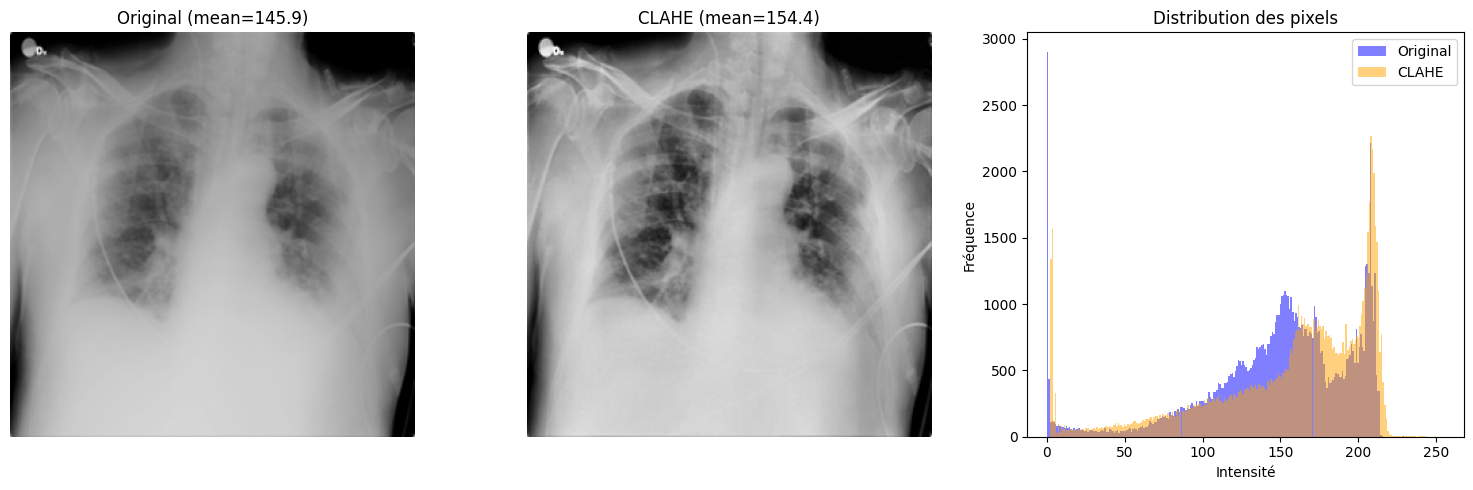

In [8]:
def apply_clahe(image, clip_limit=CLAHE_CLIP_LIMIT, tile_size=CLAHE_TILE_SIZE):
    """
    Applique CLAHE pour améliorer le contraste.
    Conclusion notebook 02: CLAHE > equalizeHist pour préserver les détails.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    return clahe.apply(image)

# Visualisation de l'effet CLAHE
sample_img_path = df_pairs.iloc[0]['image']
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
sample_clahe = apply_clahe(sample_img)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title(f'Original (mean={sample_img.mean():.1f})')
axes[0].axis('off')

axes[1].imshow(sample_clahe, cmap='gray')
axes[1].set_title(f'CLAHE (mean={sample_clahe.mean():.1f})')
axes[1].axis('off')

axes[2].hist(sample_img.ravel(), bins=256, alpha=0.5, label='Original', color='blue')
axes[2].hist(sample_clahe.ravel(), bins=256, alpha=0.5, label='CLAHE', color='orange')
axes[2].set_title('Distribution des pixels')
axes[2].legend()
axes[2].set_xlabel('Intensité')
axes[2].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

## 8. Augmentations avec Albumentations

In [9]:
def get_train_transforms():
    """
    Augmentations pour l'entraînement.
    Adaptées aux radiographies thoraciques.
    """
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),

        # Transformations géométriques
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=15,
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5
        ),

        # Transformations d'intensité (légères pour radiographies)
        A.RandomBrightnessContrast(
            brightness_limit=0.1,
            contrast_limit=0.1,
            p=0.3
        ),
        A.GaussNoise(var_limit=(5, 25), p=0.2),
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),

        # Elastic transform (utile en médical)
        A.ElasticTransform(
            alpha=50,
            sigma=50 * 0.05,
            p=0.2
        ),

        # Normalisation ImageNet (pour encodeur pré-entraîné)
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2(),
    ])

def get_val_transforms():
    """Transformations pour validation/test (pas d'augmentation)."""
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2(),
    ])

print("✅ Transformations définies")

✅ Transformations définies


## 9. Dataset PyTorch

⚠️ **Correction importante**: Les masques sont redimensionnés à 299×299 (taille des images) **avant** les transformations Albumentations.

In [10]:
class LungSegmentationDataset(Dataset):
    """
    Dataset pour la segmentation pulmonaire.

    ⚠️ IMPORTANT: Les masques sont redimensionnés à la taille des images (299x299)
    AVANT les transformations Albumentations pour éviter l'erreur:
    'Height and Width of image, mask should be equal'
    """

    def __init__(self, df, transform=None, apply_clahe=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.apply_clahe = apply_clahe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1. Chargement image en grayscale
        image = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)
        img_h, img_w = image.shape

        # 2. Chargement masque
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)

        # 3. ⚠️ CRUCIAL: Redimensionner le masque à la taille de l'image (299x299)
        #    Les masques du dataset ont une taille différente
        if mask.shape != image.shape:
            mask = cv2.resize(
                mask,
                (img_w, img_h),  # (width, height) pour cv2.resize
                interpolation=cv2.INTER_NEAREST  # Préserve les valeurs binaires
            )

        # 4. Application CLAHE sur l'image (cf. notebook 02)
        if self.apply_clahe:
            image = apply_clahe(image)

        # 5. Conversion en RGB pour encodeur pré-entraîné ImageNet
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # 6. Binarisation du masque
        mask = (mask > 127).astype(np.float32)

        # 7. Augmentations (image et masque ont maintenant la même taille)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # 8. Ajout dimension channel au masque [H, W] -> [1, H, W]
        if isinstance(mask, torch.Tensor):
            mask = mask.unsqueeze(0)
        else:
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

print("✅ Classe LungSegmentationDataset définie (avec redimensionnement masques)")

✅ Classe LungSegmentationDataset définie (avec redimensionnement masques)


In [11]:
# Création des datasets
train_dataset = LungSegmentationDataset(
    train_df,
    transform=get_train_transforms(),
    apply_clahe=APPLY_CLAHE
)

val_dataset = LungSegmentationDataset(
    val_df,
    transform=get_val_transforms(),
    apply_clahe=APPLY_CLAHE
)

test_dataset = LungSegmentationDataset(
    test_df,
    transform=get_val_transforms(),
    apply_clahe=APPLY_CLAHE
)

print(f"✅ Datasets créés:")
print(f"   Train: {len(train_dataset)}")
print(f"   Val:   {len(val_dataset)}")
print(f"   Test:  {len(test_dataset)}")

# Test rapide pour vérifier que ça fonctionne
print("\n🧪 Test de chargement d'une paire...")
test_img, test_mask = train_dataset[0]
print(f"   Image shape: {test_img.shape}")
print(f"   Mask shape:  {test_mask.shape}")
print("   ✅ OK!")

✅ Datasets créés:
   Train: 14815
   Val:   3175
   Test:  3175

🧪 Test de chargement d'une paire...
   Image shape: torch.Size([3, 256, 256])
   Mask shape:  torch.Size([1, 256, 256])
   ✅ OK!


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1487833148.py:25: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 25), p=0.2),


In [12]:
# Création des DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✅ DataLoaders créés")
print(f"   Batches train: {len(train_loader)}")
print(f"   Batches val:   {len(val_loader)}")

✅ DataLoaders créés
   Batches train: 926
   Batches val:   199


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 10. Visualisation d'un batch

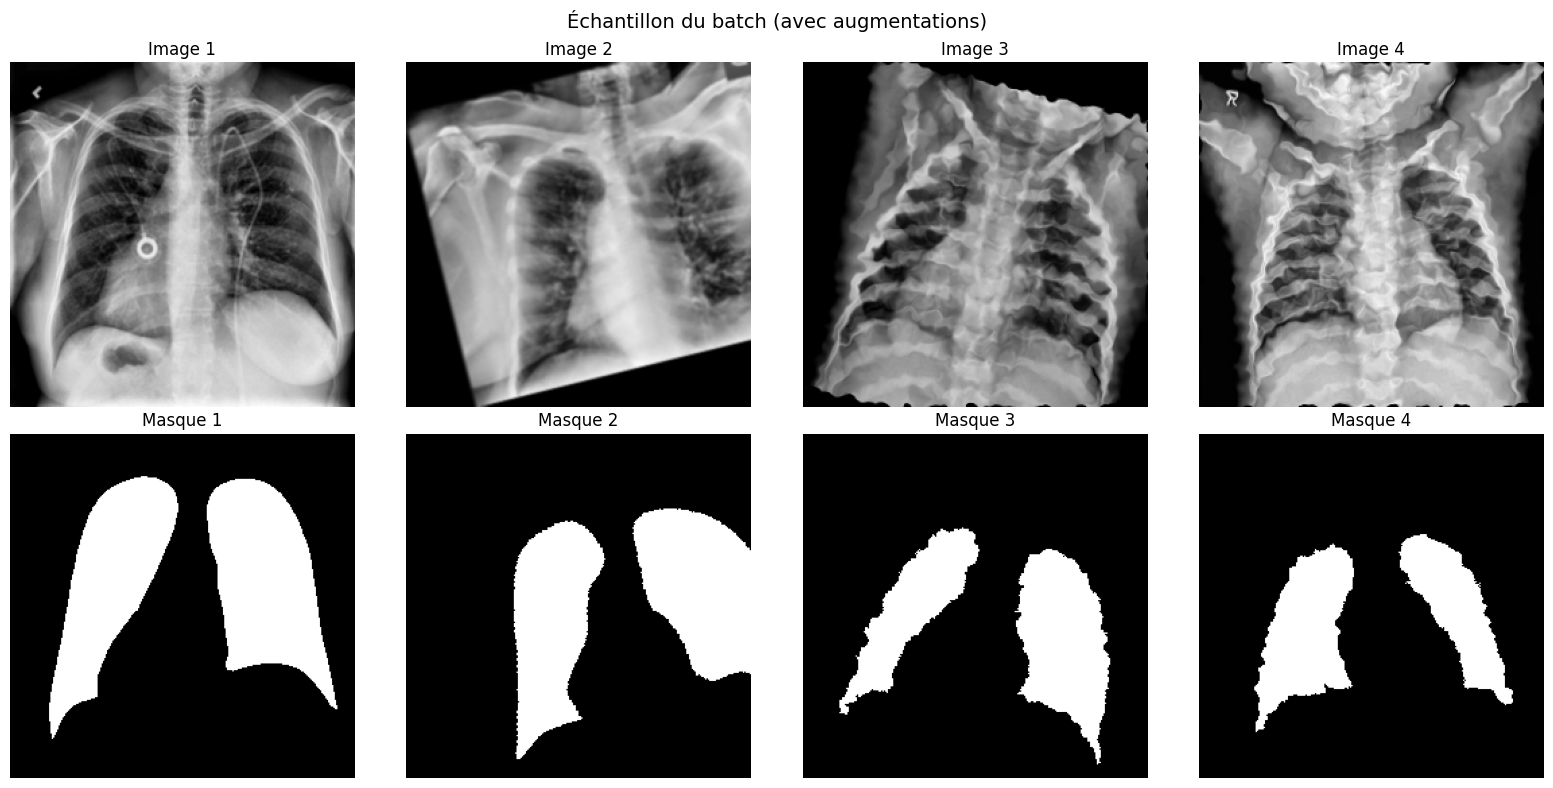

In [13]:
def visualize_batch(loader, n_samples=4):
    """Visualise un batch d'images et masques."""
    images, masks = next(iter(loader))

    fig, axes = plt.subplots(2, n_samples, figsize=(4*n_samples, 8))

    # Dénormalisation pour affichage
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(n_samples):
        # Image dénormalisée
        img = images[i] * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        # Masque
        mask = masks[i].squeeze().numpy()

        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')

        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f'Masque {i+1}')
        axes[1, i].axis('off')

    plt.suptitle('Échantillon du batch (avec augmentations)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_batch(train_loader, n_samples=4)

## 11. Définition du modèle U-Net

In [14]:
# Création du modèle U-Net avec segmentation-models-pytorch
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,          # RGB (grayscale converti)
    classes=1,              # Segmentation binaire
    activation=None         # Sigmoid appliqué dans la loss
)

model = model.to(device)

# Compte des paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Modèle U-Net créé")
print(f"   Encoder: {ENCODER}")
print(f"   Paramètres totaux: {total_params:,}")
print(f"   Paramètres entraînables: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ Modèle U-Net créé
   Encoder: resnet34
   Paramètres totaux: 24,436,369
   Paramètres entraînables: 24,436,369


## 12. Loss et métriques

In [16]:
class DiceBCELoss(nn.Module):
    """
    Combinaison Dice Loss + BCE Loss.
    Recommandé pour la segmentation médicale.
    """
    def __init__(self, dice_weight=0.5, bce_weight=0.5, smooth=1e-6):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        # BCE Loss
        bce_loss = self.bce(logits, targets)

        # Dice Loss
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (probs_flat * targets_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (
            probs_flat.sum() + targets_flat.sum() + self.smooth
        )
        dice_loss = 1 - dice_coeff

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(pred, target, threshold=0.5, smooth=1e-6):
    """Calcule le coefficient Dice (IoU-like metric)."""
    pred = (torch.sigmoid(pred) > threshold).float()

    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (
        pred_flat.sum() + target_flat.sum() + smooth
    )
    return dice.item()


def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calcule l'IoU (Intersection over Union)."""
    pred = (torch.sigmoid(pred) > threshold).float()

    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.item()


# Initialisation
criterion = DiceBCELoss(dice_weight=0.5, bce_weight=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print("✅ Loss et optimizer configurés")


✅ Loss et optimizer configurés


## 13. Boucle d'entraînement

In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Entraînement sur une epoch."""
    model.train()
    total_loss = 0
    total_dice = 0

    pbar = tqdm(loader, desc='Train')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks)

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader), total_dice / len(loader)


def validate_epoch(model, loader, criterion, device):
    """Validation sur une epoch."""
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Val'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks)
            total_iou += iou_score(outputs, masks)

    n = len(loader)
    return total_loss / n, total_dice / n, total_iou / n

print("✅ Fonctions d'entraînement définies")

✅ Fonctions d'entraînement définies


In [18]:
# Historique pour visualisation
history = {
    'train_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'lr': []
}

best_dice = 0
best_epoch = 0

print(f"\n{'='*60}")
print(f"🚀 DÉBUT DE L'ENTRAÎNEMENT")
print(f"{'='*60}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Device: {device}")
print(f"CLAHE: {APPLY_CLAHE}")
print(f"{'='*60}\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)

    # Train
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, device)

    # Learning rate actuel
    current_lr = optimizer.param_groups[0]['lr']

    # Historique
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['lr'].append(current_lr)

    # Affichage
    print(f"\n📊 Résultats:")
    print(f"   Train - Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
    print(f"   Val   - Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")
    print(f"   LR: {current_lr:.2e}")

    # Scheduler
    scheduler.step(val_dice)

    # Sauvegarde meilleur modèle
    if val_dice > best_dice:
        best_dice = val_dice
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'val_iou': val_iou,
        }, 'best_unet_lung_segmentation.pth')
        print(f"   ✅ Nouveau meilleur modèle sauvegardé! (Dice: {val_dice:.4f})")

print(f"\n{'='*60}")
print(f"🏆 ENTRAÎNEMENT TERMINÉ")
print(f"{'='*60}")
print(f"Meilleur Dice: {best_dice:.4f} (epoch {best_epoch})")


🚀 DÉBUT DE L'ENTRAÎNEMENT
Epochs: 50
Device: cuda
CLAHE: True


📅 Epoch 1/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:25<00:00,  7.94it/s]



📊 Résultats:
   Train - Loss: 0.1491 | Dice: 0.9413
   Val   - Loss: 0.0477 | Dice: 0.9791 | IoU: 0.9591
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9791)

📅 Epoch 2/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.20it/s]



📊 Résultats:
   Train - Loss: 0.0443 | Dice: 0.9727
   Val   - Loss: 0.0327 | Dice: 0.9777 | IoU: 0.9565
   LR: 1.00e-04

📅 Epoch 3/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.17it/s]



📊 Résultats:
   Train - Loss: 0.0335 | Dice: 0.9756
   Val   - Loss: 0.0229 | Dice: 0.9835 | IoU: 0.9675
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9835)

📅 Epoch 4/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.43it/s]



📊 Résultats:
   Train - Loss: 0.0299 | Dice: 0.9768
   Val   - Loss: 0.0222 | Dice: 0.9831 | IoU: 0.9669
   LR: 1.00e-04

📅 Epoch 5/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.77it/s]



📊 Résultats:
   Train - Loss: 0.0277 | Dice: 0.9780
   Val   - Loss: 0.0198 | Dice: 0.9847 | IoU: 0.9699
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9847)

📅 Epoch 6/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.70it/s]



📊 Résultats:
   Train - Loss: 0.0265 | Dice: 0.9787
   Val   - Loss: 0.0195 | Dice: 0.9845 | IoU: 0.9695
   LR: 1.00e-04

📅 Epoch 7/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.13it/s]



📊 Résultats:
   Train - Loss: 0.0258 | Dice: 0.9791
   Val   - Loss: 0.0189 | Dice: 0.9850 | IoU: 0.9705
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9850)

📅 Epoch 8/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.33it/s]



📊 Résultats:
   Train - Loss: 0.0251 | Dice: 0.9796
   Val   - Loss: 0.0191 | Dice: 0.9847 | IoU: 0.9699
   LR: 1.00e-04

📅 Epoch 9/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.16it/s]



📊 Résultats:
   Train - Loss: 0.0244 | Dice: 0.9800
   Val   - Loss: 0.0187 | Dice: 0.9849 | IoU: 0.9702
   LR: 1.00e-04

📅 Epoch 10/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.29it/s]



📊 Résultats:
   Train - Loss: 0.0241 | Dice: 0.9803
   Val   - Loss: 0.0175 | Dice: 0.9860 | IoU: 0.9725
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9860)

📅 Epoch 11/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 11.04it/s]



📊 Résultats:
   Train - Loss: 0.0236 | Dice: 0.9806
   Val   - Loss: 0.0173 | Dice: 0.9861 | IoU: 0.9727
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9861)

📅 Epoch 12/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.90it/s]



📊 Résultats:
   Train - Loss: 0.0236 | Dice: 0.9807
   Val   - Loss: 0.0168 | Dice: 0.9867 | IoU: 0.9738
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9867)

📅 Epoch 13/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.37it/s]



📊 Résultats:
   Train - Loss: 0.0230 | Dice: 0.9811
   Val   - Loss: 0.0169 | Dice: 0.9866 | IoU: 0.9735
   LR: 1.00e-04

📅 Epoch 14/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.58it/s]



📊 Résultats:
   Train - Loss: 0.0227 | Dice: 0.9813
   Val   - Loss: 0.0166 | Dice: 0.9867 | IoU: 0.9738
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9867)

📅 Epoch 15/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.38it/s]



📊 Résultats:
   Train - Loss: 0.0222 | Dice: 0.9817
   Val   - Loss: 0.0162 | Dice: 0.9871 | IoU: 0.9745
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9871)

📅 Epoch 16/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.06it/s]



📊 Résultats:
   Train - Loss: 0.0222 | Dice: 0.9817
   Val   - Loss: 0.0161 | Dice: 0.9871 | IoU: 0.9746
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9871)

📅 Epoch 17/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.65it/s]



📊 Résultats:
   Train - Loss: 0.0218 | Dice: 0.9820
   Val   - Loss: 0.0161 | Dice: 0.9872 | IoU: 0.9747
   LR: 1.00e-04
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9872)

📅 Epoch 18/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.12it/s]



📊 Résultats:
   Train - Loss: 0.0221 | Dice: 0.9818
   Val   - Loss: 0.0164 | Dice: 0.9867 | IoU: 0.9738
   LR: 1.00e-04

📅 Epoch 19/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.92it/s]



📊 Résultats:
   Train - Loss: 0.0215 | Dice: 0.9823
   Val   - Loss: 0.0165 | Dice: 0.9869 | IoU: 0.9741
   LR: 1.00e-04

📅 Epoch 20/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.49it/s]



📊 Résultats:
   Train - Loss: 0.0213 | Dice: 0.9824
   Val   - Loss: 0.0161 | Dice: 0.9870 | IoU: 0.9743
   LR: 1.00e-04

📅 Epoch 21/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.11it/s]



📊 Résultats:
   Train - Loss: 0.0214 | Dice: 0.9824
   Val   - Loss: 0.0168 | Dice: 0.9866 | IoU: 0.9736
   LR: 1.00e-04

📅 Epoch 22/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.87it/s]



📊 Résultats:
   Train - Loss: 0.0201 | Dice: 0.9834
   Val   - Loss: 0.0150 | Dice: 0.9881 | IoU: 0.9765
   LR: 5.00e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9881)

📅 Epoch 23/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.16it/s]



📊 Résultats:
   Train - Loss: 0.0198 | Dice: 0.9836
   Val   - Loss: 0.0151 | Dice: 0.9880 | IoU: 0.9764
   LR: 5.00e-05

📅 Epoch 24/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.19it/s]



📊 Résultats:
   Train - Loss: 0.0196 | Dice: 0.9837
   Val   - Loss: 0.0150 | Dice: 0.9881 | IoU: 0.9765
   LR: 5.00e-05

📅 Epoch 25/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.27it/s]



📊 Résultats:
   Train - Loss: 0.0194 | Dice: 0.9840
   Val   - Loss: 0.0151 | Dice: 0.9881 | IoU: 0.9766
   LR: 5.00e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9881)

📅 Epoch 26/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.42it/s]



📊 Résultats:
   Train - Loss: 0.0194 | Dice: 0.9839
   Val   - Loss: 0.0151 | Dice: 0.9881 | IoU: 0.9764
   LR: 5.00e-05

📅 Epoch 27/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.36it/s]



📊 Résultats:
   Train - Loss: 0.0192 | Dice: 0.9841
   Val   - Loss: 0.0152 | Dice: 0.9880 | IoU: 0.9764
   LR: 5.00e-05

📅 Epoch 28/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:22<00:00,  9.03it/s]



📊 Résultats:
   Train - Loss: 0.0192 | Dice: 0.9841
   Val   - Loss: 0.0149 | Dice: 0.9883 | IoU: 0.9769
   LR: 5.00e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9883)

📅 Epoch 29/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.58it/s]



📊 Résultats:
   Train - Loss: 0.0192 | Dice: 0.9841
   Val   - Loss: 0.0149 | Dice: 0.9882 | IoU: 0.9767
   LR: 5.00e-05

📅 Epoch 30/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.94it/s]



📊 Résultats:
   Train - Loss: 0.0190 | Dice: 0.9843
   Val   - Loss: 0.0150 | Dice: 0.9883 | IoU: 0.9769
   LR: 5.00e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9883)

📅 Epoch 31/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.47it/s]



📊 Résultats:
   Train - Loss: 0.0190 | Dice: 0.9843
   Val   - Loss: 0.0146 | Dice: 0.9885 | IoU: 0.9773
   LR: 5.00e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9885)

📅 Epoch 32/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.13it/s]



📊 Résultats:
   Train - Loss: 0.0187 | Dice: 0.9845
   Val   - Loss: 0.0149 | Dice: 0.9882 | IoU: 0.9768
   LR: 5.00e-05

📅 Epoch 33/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.73it/s]



📊 Résultats:
   Train - Loss: 0.0188 | Dice: 0.9844
   Val   - Loss: 0.0149 | Dice: 0.9883 | IoU: 0.9770
   LR: 5.00e-05

📅 Epoch 34/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.34it/s]



📊 Résultats:
   Train - Loss: 0.0186 | Dice: 0.9846
   Val   - Loss: 0.0146 | Dice: 0.9885 | IoU: 0.9773
   LR: 5.00e-05

📅 Epoch 35/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.81it/s]



📊 Résultats:
   Train - Loss: 0.0185 | Dice: 0.9847
   Val   - Loss: 0.0149 | Dice: 0.9883 | IoU: 0.9769
   LR: 5.00e-05

📅 Epoch 36/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.27it/s]



📊 Résultats:
   Train - Loss: 0.0186 | Dice: 0.9846
   Val   - Loss: 0.0149 | Dice: 0.9883 | IoU: 0.9770
   LR: 5.00e-05

📅 Epoch 37/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.12it/s]



📊 Résultats:
   Train - Loss: 0.0185 | Dice: 0.9847
   Val   - Loss: 0.0147 | Dice: 0.9886 | IoU: 0.9774
   LR: 5.00e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9886)

📅 Epoch 38/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.18it/s]



📊 Résultats:
   Train - Loss: 0.0179 | Dice: 0.9852
   Val   - Loss: 0.0145 | Dice: 0.9888 | IoU: 0.9778
   LR: 2.50e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9888)

📅 Epoch 39/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:18<00:00, 10.53it/s]



📊 Résultats:
   Train - Loss: 0.0177 | Dice: 0.9853
   Val   - Loss: 0.0143 | Dice: 0.9889 | IoU: 0.9781
   LR: 2.50e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9889)

📅 Epoch 40/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.57it/s]



📊 Résultats:
   Train - Loss: 0.0176 | Dice: 0.9854
   Val   - Loss: 0.0145 | Dice: 0.9888 | IoU: 0.9778
   LR: 2.50e-05

📅 Epoch 41/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:16<00:00, 11.75it/s]



📊 Résultats:
   Train - Loss: 0.0177 | Dice: 0.9853
   Val   - Loss: 0.0144 | Dice: 0.9888 | IoU: 0.9779
   LR: 2.50e-05

📅 Epoch 42/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.16it/s]



📊 Résultats:
   Train - Loss: 0.0175 | Dice: 0.9855
   Val   - Loss: 0.0143 | Dice: 0.9890 | IoU: 0.9783
   LR: 2.50e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9890)

📅 Epoch 43/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.42it/s]



📊 Résultats:
   Train - Loss: 0.0174 | Dice: 0.9855
   Val   - Loss: 0.0145 | Dice: 0.9888 | IoU: 0.9778
   LR: 2.50e-05

📅 Epoch 44/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.09it/s]



📊 Résultats:
   Train - Loss: 0.0174 | Dice: 0.9855
   Val   - Loss: 0.0143 | Dice: 0.9889 | IoU: 0.9781
   LR: 2.50e-05

📅 Epoch 45/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.52it/s]



📊 Résultats:
   Train - Loss: 0.0174 | Dice: 0.9856
   Val   - Loss: 0.0146 | Dice: 0.9888 | IoU: 0.9778
   LR: 2.50e-05

📅 Epoch 46/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:22<00:00,  8.89it/s]



📊 Résultats:
   Train - Loss: 0.0172 | Dice: 0.9857
   Val   - Loss: 0.0144 | Dice: 0.9890 | IoU: 0.9783
   LR: 1.25e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9890)

📅 Epoch 47/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:16<00:00, 11.87it/s]



📊 Résultats:
   Train - Loss: 0.0172 | Dice: 0.9857
   Val   - Loss: 0.0143 | Dice: 0.9890 | IoU: 0.9782
   LR: 1.25e-05

📅 Epoch 48/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.24it/s]



📊 Résultats:
   Train - Loss: 0.0170 | Dice: 0.9858
   Val   - Loss: 0.0143 | Dice: 0.9890 | IoU: 0.9784
   LR: 1.25e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9890)

📅 Epoch 49/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.53it/s]



📊 Résultats:
   Train - Loss: 0.0170 | Dice: 0.9858
   Val   - Loss: 0.0143 | Dice: 0.9891 | IoU: 0.9784
   LR: 1.25e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9891)

📅 Epoch 50/50
----------------------------------------


Val: 100%|██████████| 199/199 [00:17<00:00, 11.58it/s]



📊 Résultats:
   Train - Loss: 0.0169 | Dice: 0.9859
   Val   - Loss: 0.0143 | Dice: 0.9891 | IoU: 0.9784
   LR: 1.25e-05
   ✅ Nouveau meilleur modèle sauvegardé! (Dice: 0.9891)

🏆 ENTRAÎNEMENT TERMINÉ
Meilleur Dice: 0.9891 (epoch 50)


## 14. Visualisation des courbes d'apprentissage

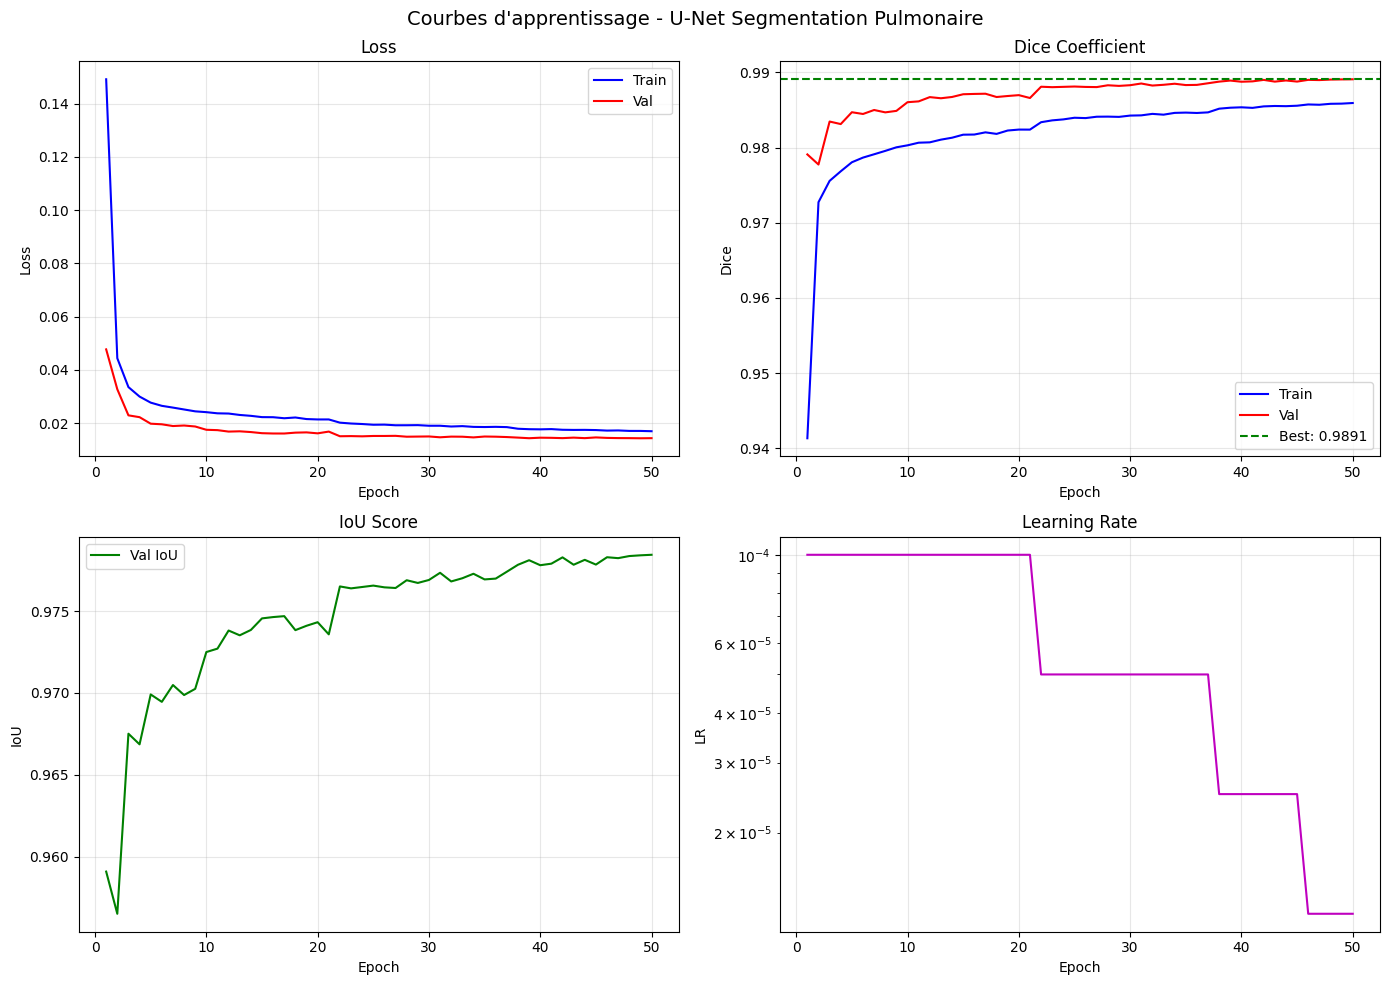

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-', label='Train')
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-', label='Val')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dice
axes[0, 1].plot(epochs_range, history['train_dice'], 'b-', label='Train')
axes[0, 1].plot(epochs_range, history['val_dice'], 'r-', label='Val')
axes[0, 1].axhline(y=best_dice, color='g', linestyle='--', label=f'Best: {best_dice:.4f}')
axes[0, 1].set_title('Dice Coefficient')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Dice')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# IoU
axes[1, 0].plot(epochs_range, history['val_iou'], 'g-', label='Val IoU')
axes[1, 0].set_title('IoU Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(epochs_range, history['lr'], 'm-')
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('LR')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Courbes d\'apprentissage - U-Net Segmentation Pulmonaire', fontsize=14)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

## 15. Évaluation sur le test set

In [20]:
# Chargement du meilleur modèle
checkpoint = torch.load('best_unet_lung_segmentation.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Meilleur modèle chargé (epoch {checkpoint['epoch']+1})")

# Évaluation sur test set
test_loss, test_dice, test_iou = validate_epoch(model, test_loader, criterion, device)

print(f"\n{'='*60}")
print(f"📊 RÉSULTATS SUR LE TEST SET")
print(f"{'='*60}")
print(f"   Loss: {test_loss:.4f}")
print(f"   Dice: {test_dice:.4f}")
print(f"   IoU:  {test_iou:.4f}")
print(f"{'='*60}")

✅ Meilleur modèle chargé (epoch 50)


Val: 100%|██████████| 199/199 [00:23<00:00,  8.29it/s]


📊 RÉSULTATS SUR LE TEST SET
   Loss: 0.0129
   Dice: 0.9897
   IoU:  0.9797


## 16. Visualisation des prédictions

In [ ]:
def visualize_predictions(model, dataset, n_samples=6, device='cuda'):
    """Visualise les prédictions du modèle."""
    model.eval()

    # Sélection aléatoire
    indices = np.random.choice(len(dataset), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))

    # Dénormalisation
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask_true = dataset[idx]

            # Prédiction
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            mask_pred = (torch.sigmoid(output) > 0.5).float().cpu().squeeze()

            # Dénormalisation image
            img_display = image * std + mean
            img_display = img_display.permute(1, 2, 0).numpy()
            img_display = np.clip(img_display, 0, 1)

            # Calcul Dice pour cette image
            dice = dice_coefficient(
                output.cpu(),
                mask_true.unsqueeze(0)
            )

            # Affichage
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Image (CLAHE)' if APPLY_CLAHE else 'Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_true.squeeze(), cmap='gray')
            axes[i, 1].set_title('Masque réel')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(mask_pred, cmap='gray')
            axes[i, 2].set_title(f'Prédiction (Dice: {dice:.3f})')
            axes[i, 2].axis('off')

            # Superposition
            overlay = img_display.copy()
            mask_np = mask_pred.numpy()
            overlay[mask_np > 0.5] = [0, 1, 0]  # Vert
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('Superposition')
            axes[i, 3].axis('off')

    plt.suptitle('Prédictions du modèle U-Net', fontsize=14)
    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=150)
    plt.show()

visualize_predictions(model, test_dataset, n_samples=6, device=device)

## 17. Export du modèle pour production

In [ ]:
# Sauvegarde finale avec métadonnées
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': {
        'encoder': ENCODER,
        'img_size': IMG_SIZE,
        'original_size': ORIGINAL_SIZE,
        'apply_clahe': APPLY_CLAHE,
        'clahe_clip_limit': CLAHE_CLIP_LIMIT,
        'clahe_tile_size': CLAHE_TILE_SIZE,
    },
    'metrics': {
        'test_dice': test_dice,
        'test_iou': test_iou,
        'best_val_dice': best_dice,
    },
    'history': history,
}

torch.save(final_checkpoint, 'unet_lung_segmentation_final.pth')
print("✅ Modèle final exporté: unet_lung_segmentation_final.pth")

## 18. Fonction d'inférence réutilisable

In [23]:
def predict_lung_mask(image_path, model, device='cuda', apply_clahe=True, img_size=256):
    """
    Prédit le masque pulmonaire pour une nouvelle image.

    Args:
        image_path: Chemin vers l'image
        model: Modèle U-Net chargé
        device: 'cuda' ou 'cpu'
        apply_clahe: Appliquer CLAHE (recommandé)
        img_size: Taille d'entrée du réseau

    Returns:
        mask: Masque binaire numpy array (taille originale)
    """
    model.eval()

    # Chargement et preprocessing
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_size = image.shape[:2]  # (H, W)

    # CLAHE
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)

    # Conversion RGB et resize
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (img_size, img_size))

    # Normalisation ImageNet
    image = image.astype(np.float32) / 255.0
    image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()

    # Prédiction
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        mask = (torch.sigmoid(output) > 0.5).float().cpu().squeeze().numpy()

    # Resize au format original
    mask = cv2.resize(mask, (original_size[1], original_size[0]))  # (W, H)
    mask = (mask > 0.5).astype(np.uint8)

    return mask


# Test de la fonction
test_image_path = test_df.iloc[0]['image']
predicted_mask = predict_lung_mask(test_image_path, model, device=device, img_size=IMG_SIZE)

print(f"✅ Fonction d'inférence prête")
print(f"   Taille masque: {predicted_mask.shape}")
print(f"   Valeurs uniques: {np.unique(predicted_mask)}")

✅ Fonction d'inférence prête
   Taille masque: (299, 299)
   Valeurs uniques: [0 1]


## 19. Résumé et conclusions

### Pipeline intégré (conclusions notebooks 01 & 02)
1. **Redimensionnement masques** → 299×299 (taille images)
2. **CLAHE** appliqué sur les images grayscale
3. **U-Net** avec encodeur ResNet34 pré-entraîné
4. **Loss** : Dice + BCE combinées
5. **Augmentations** adaptées aux radiographies

### Prochaines étapes
- Utiliser ce modèle pour générer des masques sur de nouvelles images
- Intégrer dans le pipeline de classification (CLAHE + Masque)
- Tester l'impact sur les performances de classification COVID vs Normal

In [24]:
# Résumé final
print("\n" + "="*60)
print("📋 RÉSUMÉ DU NOTEBOOK 03 - SEGMENTATION PULMONAIRE")
print("="*60)
print(f"\n🔧 Configuration:")
print(f"   - Taille originale: {ORIGINAL_SIZE}x{ORIGINAL_SIZE}")
print(f"   - Taille réseau: {IMG_SIZE}x{IMG_SIZE}")
print(f"   - Encoder: {ENCODER}")
print(f"   - CLAHE: {APPLY_CLAHE}")
print(f"   - Epochs: {NUM_EPOCHS}")
print(f"\n📊 Métriques finales (Test):")
print(f"   - Dice: {test_dice:.4f}")
print(f"   - IoU:  {test_iou:.4f}")
print(f"\n💾 Fichiers générés:")
print(f"   - best_unet_lung_segmentation.pth")
print(f"   - unet_lung_segmentation_final.pth")
print(f"   - training_curves.png")
print(f"   - predictions_visualization.png")
print("\n" + "="*60)


📋 RÉSUMÉ DU NOTEBOOK 03 - SEGMENTATION PULMONAIRE

🔧 Configuration:
   - Taille originale: 299x299
   - Taille réseau: 256x256
   - Encoder: resnet34
   - CLAHE: True
   - Epochs: 50

📊 Métriques finales (Test):
   - Dice: 0.9897
   - IoU:  0.9797

💾 Fichiers générés:
   - best_unet_lung_segmentation.pth
   - unet_lung_segmentation_final.pth
   - training_curves.png
   - predictions_visualization.png

